## Gig Economy Project

By: Janet Taylor & Evan Kessler

Workers in the gig economy (i.e., Uber, GrubHub, TaskRabbit, etc.) depend on the reviews they get to continue working on the platform. Workers on those platforms are often affected by receiving negative reviews that describe elements that were not under their control. The project explores how the analysis of online reviews can detect when unfair reviews are left to workers and identify the type of unfair review that was left.

In [34]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import checkpoint2
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we loaded the .csv files containing the data we cleaned in checkpoint 1. For the purpose of this checkpoint, we only labeling and train on Uber data. The reason why is because Uber has an additional parameter - "Invited" - that can provide additional insight as to if the review was requested by the company. This is set to false for all Lyft reviews.

In [35]:
uber = pd.read_csv("uber_cleaned.csv")
lyft = pd.read_csv("lyft_cleaned.csv")
pd.options.display.max_colwidth = 500

We preprocess the reviews before doing anything to them. Our first preprocessing step is to remove punctuation (preventing things like "for," being a considered word than "for") and the second step is to correct grammar using TextBlob's .correct() function. Incorrect corrections do not make that much of a difference, while correct ones greatly standardize inputs to the model and therefore result in higher accuracy.

In [36]:
uber["Review Body"] = checkpoint2.preprocess_reviews(uber)

We then convert sentiment to a single number for each word in the dataset and plot the sentiment of the bottom 20 and top 20 words. As expected, words like "stuck", "rude", and "worst" have very negative connotations, while "excellent", "pleasant", and "prompt" have good sentiment values. The get_sentiment_and_counts function also excludes any stopwords and words with length <= 2. Stopwords are words like "the" which are neutral. The sentiment of a review is the sum of the sentiment of all its words.

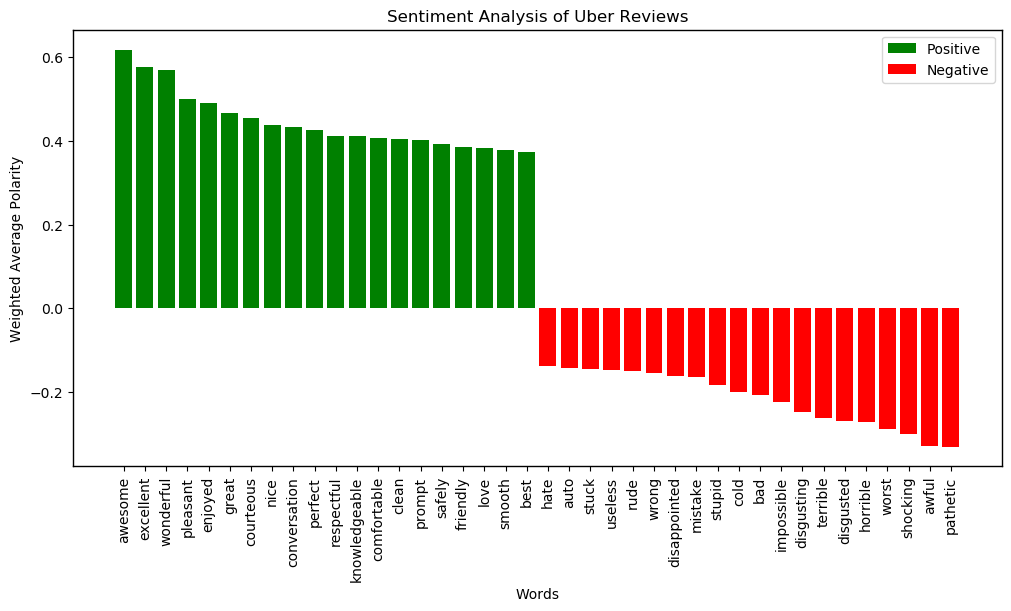

In [37]:
sentiment = checkpoint2.get_weighed_sentiment_counts(checkpoint2.get_sentiment_and_counts(uber))
uber['Sentiment'] = [sum([sentiment[word] if word in sentiment else 0 for word in str(review).split()]) for review in uber['Review Body']]

checkpoint2.plot_sentiment(dict(list(sentiment.items())[:20]), dict(list(sentiment.items())[-20:]))

Sentiment does not depend on unfairness, and it is independant of other variables, so all reviews in the dataset are used for calculating it. The following steps require an "unfair" column to train on. We labeled 650 rows of the Uber dataset for the purposes of this checkpoint.

In [38]:
labeled = uber[uber.Unfair.notnull()].astype({'Invited': 'int32', "Unfair": 'int32'})
print(labeled.shape)
X_labeled = labeled.iloc[:, labeled.columns != 'Unfair']
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

(650, 15)


We initially thought to use a NaiveBayesClassifier to classify reviews. We only used a training set to train the classifier instead of the entire set, because it is not independant and will make the model evaluation unreliable. As seen below, it is around 81% accurate and tends to be very pessimistic. This did not seem good enough for us.

In [39]:
cl_train = []
for x, y in zip(X_train["Review Body"], y_train):
    cl_train.append((x, y))

cl = NaiveBayesClassifier(cl_train, format='json')

predictions = [cl.classify(item) for item in X_test["Review Body"]]
checkpoint2.print_metrics(y_test, predictions)

labeled['BayesResult'] = [cl.classify(x) for x in labeled["Review Body"]]
X_labeled = labeled.iloc[:, labeled.columns.isin(["# Reviews By User", "Invited", "Rating", "Sentiment", "BayesResult"])]
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

Accuracy: 0.8093023255813954
Recall: 0.53125
Precision: 0.3953488372093023
F1: 0.45333333333333325


We tried several different kernels and hyperparameters for the main model, and the SVC model below performed the best.
To see how effective our preprocessing / extra columns were in the end result, we performed SVC several times, excluding certain columns from the dataset each time.

The model with the Bayes classifier and the model including both Bayes and Sentiment were the most accurate. The model with Bayes was more pessimistic and viewed two reviews as fair when we labeled them unfair, while the model without it was more optimistic and inaccurately labeled two unfair instead.

SVC kernel is poly


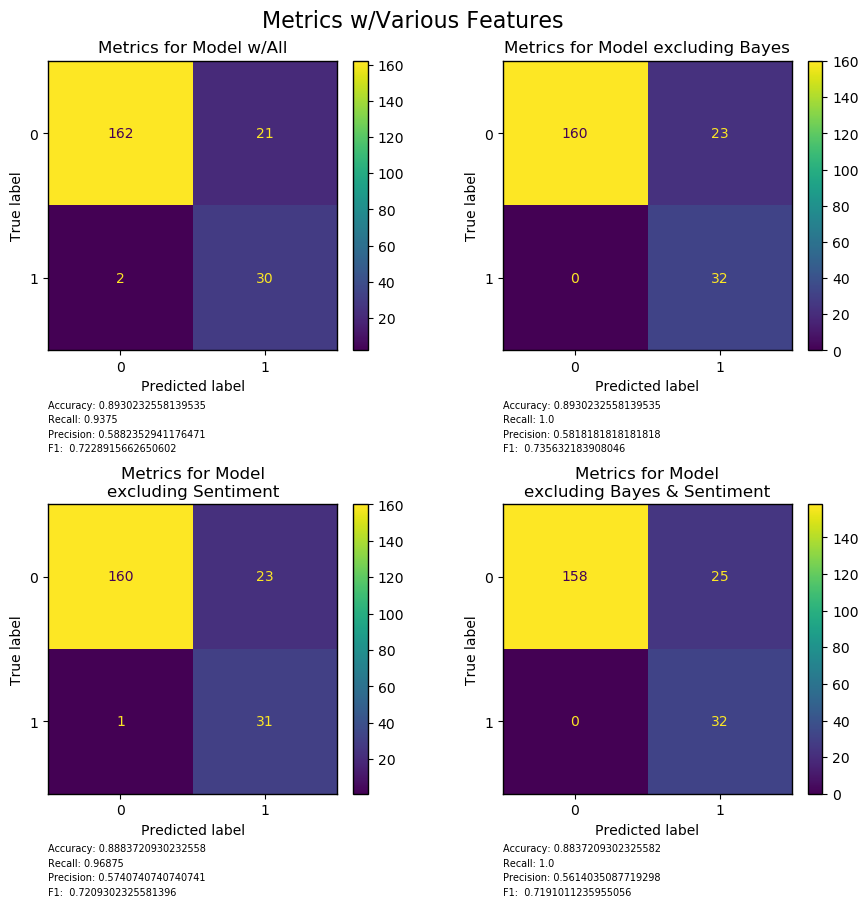

In [40]:

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

kernel = 'poly'
svc = SVC(kernel=kernel, degree=8, class_weight='balanced', coef0=2.4)
print("SVC kernel is " + kernel)

all_include = checkpoint2.perform_SVC(svc, [], X_train, y_train, X_test, y_test)
bayes_exclude = checkpoint2.perform_SVC(svc, ["BayesResult"], X_train, y_train, X_test, y_test)
sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment"], X_train, y_train, X_test, y_test)
bayes_sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment", "BayesResult"], X_train, y_train, X_test, y_test)

figure, axis = plt.subplots(2, 2, figsize=(9, 9))
figure.suptitle("Metrics w/Various Features", fontsize=16, ha='center')
checkpoint2.plot_metrics(all_include, "Metrics for Model w/All", ax=axis[0, 0])
checkpoint2.plot_metrics(bayes_exclude, "Metrics for Model excluding Bayes", ax=axis[0, 1])
checkpoint2.plot_metrics(sent_exclude, "Metrics for Model\nexcluding Sentiment", ax=axis[1, 0])
checkpoint2.plot_metrics(bayes_sent_exclude, "Metrics for Model\nexcluding Bayes & Sentiment", ax=axis[1, 1])

Here is the "all" model with some tests run on it:

In [41]:
final = SVC(kernel=kernel, degree=8, class_weight='balanced', coef0=2.4).fit(X_labeled, y_labeled)

In [80]:
reviews = ["the driver was bad and the ride was awful", "the driver was wonderful but the ride was too expensive", "loved the ride it was safe and the driver was talkative"]

custom_cases_array = [
    [3, 1, 1, reviews[0], sum([sentiment[word] if word in sentiment else 0 for word in reviews[0].split()]), cl.classify(reviews[0])],
    [1, 0, 1, reviews[1],sum([sentiment[word] if word in sentiment else 0 for word in reviews[1].split()]), cl.classify(reviews[1])],
    [8, 1, 5, reviews[2],sum([sentiment[word] if word in sentiment else 0 for word in reviews[2].split()]), cl.classify(reviews[2])],
    ]
custom_cases = pd.DataFrame(custom_cases_array, columns=['# Reviews By User', "Invited", "Rating", "Review Body", "Sentiment", "BayesResult"])
custom_cases.drop('Review Body', axis=1, inplace=True)
predictions = final.predict(custom_cases)

for i in range(len(reviews)):
    rating = custom_cases_array[i][2]
    if predictions[i]:
        print(f"'{reviews[i]}', which was given {rating} star(s), is an UNFAIR review.")
    else:
        print(f"'{reviews[i]}', which was given {rating} star(s), is a FAIR review.")

'the driver was bad and the ride was awful', which was given 1 star(s), is a FAIR review.
'the driver was wonderful but the ride was too expensive', which was given 1 star(s), is an UNFAIR review.
'loved the ride it was safe and the driver was talkative', which was given 5 star(s), is a FAIR review.
